# Подключение гугл диска

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Импорт библиотек

In [ ]:
!pip install catboost
!pip install shap

import shap
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
import pandas as pd
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Шаг 1. Загрузка данных и удаление выбросов

In [ ]:
# Чтобы выполнить загрузку, нужно положить данные на свой гугл диск
data = pd.read_csv('/content/drive/MyDrive/real_estate_data.csv', sep='\t')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Описание:

- airports_nearest — расстояние до ближайшего аэропорта в метрах (м)

- balcony — число балконов

- ceiling_height — высота потолков (м)

- cityCenters_nearest — расстояние до центра города (м)

- days_exposition — сколько дней было размещено объявление (от публикации до снятия)

- first_day_exposition — дата публикации

- floor — этаж

- floors_total — всего этажей в доме

- is_apartment — апартаменты (булев тип)

- kitchen_area — площадь кухни в квадратных метрах (м²)

- last_price — цена на момент снятия с публикации

- living_area — жилая площадь в квадратных метрах(м²)

- locality_name — название населённого пункта

- open_plan — свободная планировка (булев тип)

- parks_around3000 — число парков в радиусе 3 км

- parks_nearest — расстояние до ближайшего парка (м)

- ponds_around3000 — число водоёмов в радиусе 3 км

- ponds_nearest — расстояние до ближайшего водоёма (м)

- rooms — число комнат

- studio — квартира-студия (булев тип)

- total_area — площадь квартиры в квадратных метрах (м²)

- total_images — число фотографий квартиры в объявлении

Пояснение: апартаменты — это нежилые помещения, не относящиеся к жилому фонду, но имеющие необходимые условия для проживания.


## Удаление выбросов

Удалим из датасета выбросы - воспользуемся методом, взятым с Kaggle (https://www.kaggle.com/code/hgultekin/box-plots-finding-all-outliers/notebook), но немного переделаем его под наши нужды - будем возвращать не Series выбросов, а уже очищенный. Следует отметить, что, по всей видимости, в boxplot используется немного другой способ вычисления, поэтому на графиках всё ещё будут оставаться чёрные точки, но уже не такие экстремальные. В любом случае мы гарантированно получим для каждого признака точки, которые лежат в заданных пределах, просто эти пределы будут чуть по-другому определены

In [ ]:
def box_outliers(df, col_name):
    Q1 = df[col_name].quantile(0.25)
    Q3 = df[col_name].quantile(0.75)
    IQR = Q3 - Q1
    mask = (df[col_name] < Q1 - 1.5 * IQR) | (df[col_name] > Q3 + 1.5 * IQR)
    df = df.drop(df[mask].index)
    return df

Проверим сначала на примере времени продажи

До преобразования

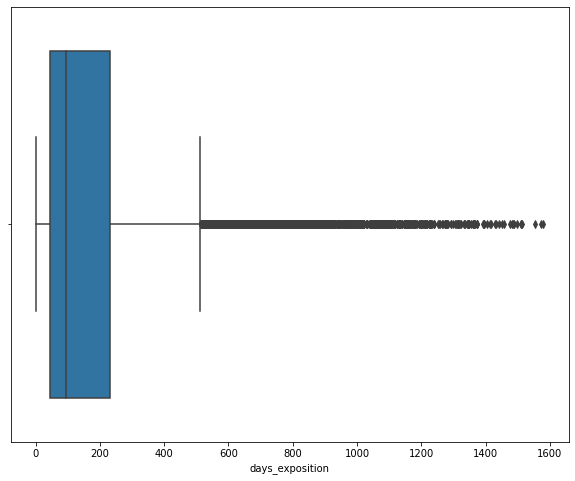

In [ ]:
sns.boxplot(x='days_exposition', data=data);

После преобразования

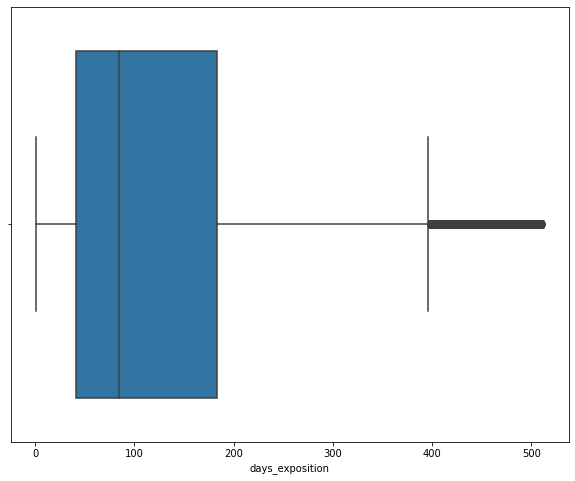

In [ ]:
df = data.copy()
df = pd.DataFrame(box_outliers(df, 'days_exposition'))
sns.boxplot(x='days_exposition', data=df);

Видим, что уже стало гораздо лучше. Теперь запустим цикл по всем числовым 
признакам и очистим датасет

In [ ]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_cols = data.select_dtypes(include=numerics)
num_cols.head()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,3,2.70,16.0,51.0,8,25.0,NaN,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,1,NaN,11.0,18.6,1,11.0,2.0,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2,NaN,5.0,34.3,4,8.3,0.0,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,3,NaN,14.0,NaN,9,NaN,0.0,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2,3.03,14.0,32.0,13,41.0,NaN,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Сформируем список ненулевых числовых столбцов. Это нужно для того, чтобы показать на некоторых признаках, как меняется график boxplot до и после нашего преобразования. Если в признаке присутствует значение Nan, то график просто не отрисуется, и у нас будет пустой холст

При этом мы намеренно избавляемся от выбросов до заполнения пропусков, т.к.,иначе, после заполнения статистиками мы не сможем адекватно применить формулу для выброса (из-за того, что часть наших данных станет фиктивной). При этом, в обратную сторону, отсутствие выбросов должно приблизить статистики среднее/медиану к реальному мат. ожиданию, чему мы должны только радоваться



In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [ ]:
num_cols_without_nan = ['total_images', 'last_price', 'total_area', 'rooms']

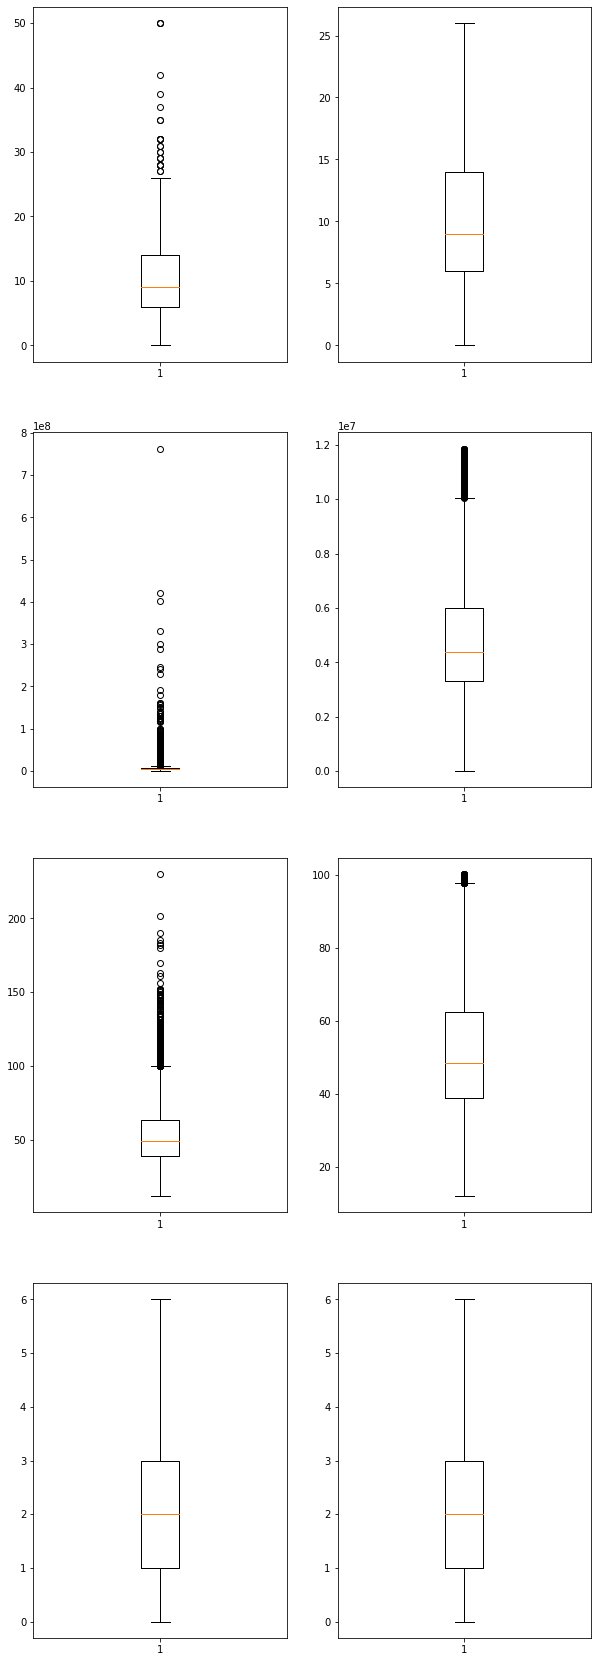

In [ ]:
num_of_cols = 2
num_of_rows = 4

fig, axs = plt.subplots(num_of_rows, num_of_cols, figsize=(10, 30))

for x, i in zip(num_cols.columns, range(0, 17)):
    if x in num_cols_without_nan:
        axs[i][0].boxplot(x=x, data=data);

    data = box_outliers(data, x)

    if x in num_cols_without_nan:
        axs[i][1].boxplot(x=x, data=data);

In [ ]:
data.shape

(15175, 22)

# Шаг 2. Предобработка данных

## Заполнение пропусков

Выведем полную информацию о датафрейме

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15175 entries, 1 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          15175 non-null  int64  
 1   last_price            15175 non-null  float64
 2   total_area            15175 non-null  float64
 3   first_day_exposition  15175 non-null  object 
 4   rooms                 15175 non-null  int64  
 5   ceiling_height        9043 non-null   float64
 6   floors_total          15137 non-null  float64
 7   living_area           13881 non-null  float64
 8   floor                 15175 non-null  int64  
 9   is_apartment          1649 non-null   object 
 10  studio                15175 non-null  bool   
 11  open_plan             15175 non-null  bool   
 12  kitchen_area          13625 non-null  float64
 13  balcony               7958 non-null   float64
 14  locality_name         15156 non-null  object 
 15  airports_nearest   

Выведем основные статистики

In [ ]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,15175.000000,1.517500e+04,15175.000000,15175.000000,9043.000000,15137.000000,13881.000000,15175.000000,13625.000000,7958.000000,10479.000000,10489.000000,10490.000000,3940.000000,10490.000000,4458.000000,13168.000000
mean,9.742076,4.497193e+06,50.436381,1.866689,2.636041,10.785030,29.098793,5.522965,8.904773,1.157577,28591.041225,13231.372199,0.450906,462.102030,0.512011,575.915433,114.457397
std,5.472558,1.988256e+06,15.733047,0.860637,0.146407,6.238989,11.488657,4.007241,2.612188,1.018640,12835.513006,4090.091901,0.631068,216.481922,0.651127,277.607532,107.120296
min,0.000000,4.300000e+05,13.000000,0.000000,2.200000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,2419.000000,0.000000,1.000000,0.000000,20.000000,1.000000
25%,6.000000,3.200000e+06,38.000000,1.000000,2.500000,5.000000,18.000000,2.000000,7.000000,0.000000,16501.000000,11088.000000,0.000000,309.000000,0.000000,364.000000,37.000000
50%,9.000000,4.200000e+06,47.000000,2.000000,2.600000,9.000000,28.600000,4.000000,8.500000,1.000000,28501.000000,13277.000000,0.000000,466.500000,0.000000,582.000000,74.000000
75%,14.000000,5.536036e+06,60.100000,2.000000,2.700000,16.000000,37.300000,8.000000,10.500000,2.000000,38190.000000,15664.000000,1.000000,611.000000,1.000000,792.000000,163.000000
max,26.000000,1.180000e+07,100.200000,5.000000,3.120000,28.000000,68.000000,17.000000,16.800000,5.000000,61710.000000,25308.000000,2.000000,1103.000000,2.000000,1344.000000,452.000000


Посмотрим на пропущенные значения

In [ ]:
data.isnull().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           6132
floors_total               38
living_area              1294
floor                       0
is_apartment            13526
studio                      0
open_plan                   0
kitchen_area             1550
balcony                  7217
locality_name              19
airports_nearest         4696
cityCenters_nearest      4686
parks_around3000         4685
parks_nearest           11235
ponds_around3000         4685
ponds_nearest           10717
days_exposition          2007
dtype: int64

Видим, что есть много пропусков. Определим стратегию их заполнения. Слышал, что для моделирования рекомендуют удалять столбцы с 30+% пропусков (для нашей задачи это 7000)-пока будем считать, что это не нужно

ceiling_height - высота потолков. В целом, было бы логично заполнить столбец средним значением по столбцу, т.к. каждый потолок имеет высоту, а среднее такого распределения должно хорошо оцениваться выборочным средним, но можно взять и медиану

In [ ]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

floors_total - всего этажей в доме. Было бы логично заполнить медианой, т.к. каждый дом имеет количество этажей, но этаж не может быть дробным числом, а среднее, скорее всего, даст дробное значение

In [ ]:
data['floors_total'] = data['floors_total'].fillna(data['floors_total'].median())

living_area - площадь. Опять же, числовой признак, можно заполнить средним или медианой

In [ ]:
data['living_area'] = data['living_area'].fillna(data['living_area'].median())

is_apartment - апартаменты. Здесь у нас 21к пропусков и булев тип, т.е. заполнить чем-то разумным особо нельзя. Возможно, через ML-модель мы могли бы научиться восстанавливать этот флаг, но подход замороченный + нет гарантий, что он принесёт больше пользы, чем просто оставить всё как есть/удалить столбец

kitchen_area - площать кухни. Заполним медианой аналогично living_area

In [ ]:
data['kitchen_area'] = data['kitchen_area'].fillna(data['kitchen_area'].median())

balcony - число балконов. Можно заполнить нулями, как сказано в задании, хотя медиана тоже кажется довольно удачным заполнителем (скорее всего, тоже равна 0 или 1), аналогично floors_total - по причине невозможности дробных значений

In [ ]:
data['balcony'] = data['balcony'].fillna(0)

locality_name - название населённого пункта. Это категориальный признак, выглядит как будто для него нет разумных предположений

airports_nearest - расстояние до ближ. аэропорта. Числовой признак, можно заполнить средним или медианой

In [ ]:
data['airports_nearest'] = data['airports_nearest'].fillna(data['airports_nearest'].median())

cityCenters_nearest - расстояние до центра города. Числовой признак, можно заполнить средним или медианой

In [ ]:
data['cityCenters_nearest'] = data['cityCenters_nearest'].fillna(data['cityCenters_nearest'].median())

parks_arount3000 - число парков в радиусе 3000 км. Можно заполнить медианой в силу невозможности дробных значений или нулями (предположить, что если не заполнено, то их и нет), как и в случае с балконами

In [ ]:
data['parks_around3000'] = data['parks_around3000'].fillna(0)

ponds_around3000 - число водоёмов в радиусе 3000 км. Можно заполнить нулями аналогично parks_around3000.

In [ ]:
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)

parks_nearest, ponds_nearest - можно заполнить средним или медианой аналогично airports_nearest

In [ ]:
data['parks_nearest'] = data['parks_nearest'].fillna(data['parks_nearest'].median())
data['ponds_nearest'] = data['ponds_nearest'].fillna(data['ponds_nearest'].median())

days_exposition - сколько дней было размещено объявление. Можно, опять же, заполнить медианой по соображениям, связанным с невозможностью дробных значений

In [ ]:
data['days_exposition'] = data['days_exposition'].fillna(data['days_exposition'].median())

Ещё раз посмотрим на таблицу пропусков

In [ ]:
data.isnull().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment            13526
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name              19
airports_nearest            0
cityCenters_nearest         0
parks_around3000            0
parks_nearest               0
ponds_around3000            0
ponds_nearest               0
days_exposition             0
dtype: int64

Видим, что пропуски остались только в признаках, для которых мы приняли решение их не заполнять

Насчёт причин, у меня нет большого опыта, но кажется, что это должно быть связно с отсутствием информации в самом объявлении. Также могут быть ошибки в заполнении, если данные размечаются людьми. Наименее вероятными мне кажутся технологические причины, при которых часть значений внезапно затерялась из-за какой-то операции 

## Преобразование типов

Было бы логично заменить типы столбцов:

1) balcony, parks_around3000, pounds_around3000, days_exposition (float -> int), т.к. значения этих столбцов не могут быть дробными значениями

2) first_day_exposition в datetime, т.к. признак представляет собой дату

Изменяя типы, мы ограничиваем себя же от совершения неверных операций, а также некоторые методы начинают вести себя более разумно (например, выбор отображаемых статистик в describe) + некоторые вообще нельзя вызвать с неверным типам (например, dt.day)

Определим метод, который изменяет типы столбцов

In [ ]:
def transform_types(data: pd.DataFrame,
                    change_type_columns: dict) -> pd.DataFrame:
    """
    Преобразование набора признаков в заданный тип данных
    :param data: датасет
    :param change_type_columns: словарь с признаками и типами данных
    :return: преобразованный датасет
    """
    return data.astype(change_type_columns, errors="raise")

Определим словарь с назвваниями столбцов и типами данных

In [ ]:
change_type_columns = { 'balcony': 'int64',
                       'parks_around3000': 'int64',
                       'parks_around3000': 'int64',
                       'first_day_exposition': 'datetime64[ns]',
                       }

Преобразуем типы

In [ ]:
data = transform_types(data, change_type_columns)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15175 entries, 1 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          15175 non-null  int64         
 1   last_price            15175 non-null  float64       
 2   total_area            15175 non-null  float64       
 3   first_day_exposition  15175 non-null  datetime64[ns]
 4   rooms                 15175 non-null  int64         
 5   ceiling_height        15175 non-null  float64       
 6   floors_total          15175 non-null  float64       
 7   living_area           15175 non-null  float64       
 8   floor                 15175 non-null  int64         
 9   is_apartment          1649 non-null   object        
 10  studio                15175 non-null  bool          
 11  open_plan             15175 non-null  bool          
 12  kitchen_area          15175 non-null  float64       
 13  balcony         

# Шаг 3. Добавление признаков

Цену квадратного метра можно рассчитать как отношение стоимости к площади

In [ ]:
data['price_of_1m'] = data['last_price'] / data['total_area']
data['price_of_1m']

1         82920.792079
5         95065.789474
6         99195.710456
9         88524.590164
10       127525.252525
             ...      
23690    105769.230769
23692     45000.000000
23695     52542.372881
23696     44091.710758
23698     41795.665635
Name: price_of_1m, Length: 15175, dtype: float64

Извлечём из даты день недели, месяц и год

In [ ]:
data['month'] = data['first_day_exposition'].dt.month
data['month']

1        12
5         9
6        11
9         2
10       11
         ..
23690     7
23692     7
23695     1
23696     2
23698     7
Name: month, Length: 15175, dtype: int64

In [ ]:
data['year'] = data['first_day_exposition'].dt.year
data['year']

1        2018
5        2018
6        2017
9        2017
10       2017
         ... 
23690    2018
23692    2017
23695    2018
23696    2018
23698    2017
Name: year, Length: 15175, dtype: int64

In [ ]:
data['day_of_week'] = data['first_day_exposition'].dt.dayofweek
data['day_of_week']

1        1
5        0
6        3
9        6
10       3
        ..
23690    3
23692    4
23695    0
23696    6
23698    4
Name: day_of_week, Length: 15175, dtype: int64

Напишем функцию, которая принимает на вход этаж и возвращает категорию (первый, другой)

In [ ]:
def floor(floor: int) -> str:
    if floor == 1:
        return 'первый'
    else:
        return 'другой'

Создадим признак, выражающий категорию этажа

In [ ]:
data['floor_cat'] = data['floor'].map(floor)
data['floor_cat']

1        первый
5        другой
6        другой
9        другой
10       другой
          ...  
23690    другой
23692    другой
23695    другой
23696    первый
23698    первый
Name: floor_cat, Length: 15175, dtype: object

Заменим в признаке 'другой' на 'последний', если этаж последний

In [ ]:
indices = data[data['floor'] == data['floors_total']]['floor_cat'].index
for i in indices: 
    data.at[i, 'floor_cat'] = 'последний'

data['floor_cat'].unique()

array(['первый', 'другой', 'последний'], dtype=object)

Создадим новые признаки - отношение жилой площади к общей и отношение площади кухни к общей

In [ ]:
data['area_live_to_total'] = data['living_area'] / data['total_area']
data['area_live_to_total']

1        0.460396
5        0.473684
6        0.284182
9        0.714754
10       0.512626
           ...   
23690    0.596154
23692    0.583333
23695    0.644068
23696    0.523810
23698    0.380805
Name: area_live_to_total, Length: 15175, dtype: float64

In [ ]:
data['kitchen_live_to_total'] = data['kitchen_area'] / data['total_area']
data['kitchen_live_to_total']

1        0.272277
5        0.299342
6        0.386059
9        0.106557
10       0.214646
           ...   
23690    0.115385
23692    0.200000
23695    0.144068
23696    0.149912
23698    0.278638
Name: kitchen_live_to_total, Length: 15175, dtype: float64

# Шаг 4. Исследовательский анализ данных

## Построение графиков распределений

Определим функцию подписи текста на график столбчатой диаграммы

In [ ]:
def plot_text(ax):
    """
    Добавление подписи процентов на график barplot
    :param ax: ось
    :return: None
    """
    for p in ax.patches:
        percentage = '{:.2f}%'.format(p.get_height())
        ax.annotate(
            percentage,  # текст
            # координата xy
            (p.get_x() + p.get_width() / 2., p.get_height()),
            # центрирование
            ha='center',
            va='center',
            xytext=(0, 10),
            # точка смещения относительно координаты
            textcoords='offset points',
            fontsize=8)

Определим саму функцию построения столбчатой гистограммы

In [ ]:
def barplot(df: pd.DataFrame,
            col: str,
            title: str) -> None:
    """
    Построение графика распределения признака в виде столбчатой диаграммы
    :param df: датасет
    :param col: столбец, для которого которого хотим смотреть распределение
    :param title: заголовок
    :return: None
    """
    rcParams['figure.figsize'] = 10, 8
    sns.color_palette("YlOrBr", as_cmap=True)

    # Датафрейм частот значений
    norm_target = pd.DataFrame(df[col].value_counts(normalize=True).mul(100) \
                               .rename('percent')).reset_index()

    ax = sns.barplot(x='index', y='percent', data=norm_target, palette="flare")
    plt.title(title)
    plot_text(ax)

Построим гистограммы для числа комнат

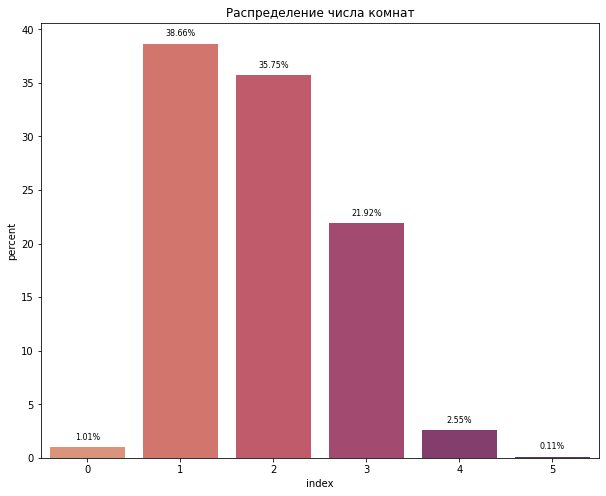

In [ ]:
barplot(df=data,
        col='rooms',
        title='Распределение числа комнат')

Построим гистограммы для площади, цены и высоты потолков

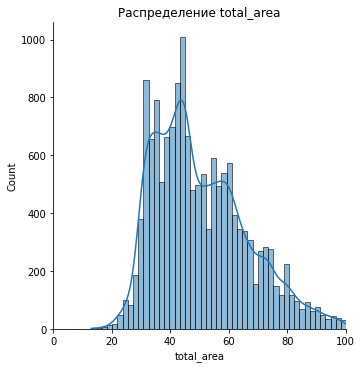

In [ ]:
sns.displot(
  data=data['total_area'],
  kde=True,
  common_norm=False)

plt.xlim(0, 100)
plt.title('Распределение total_area');

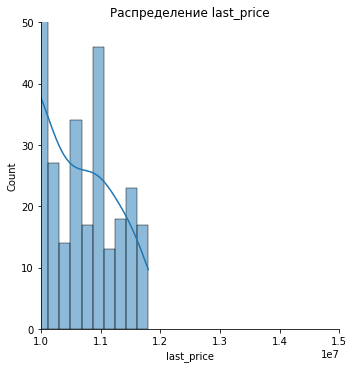

In [ ]:
sns.displot(
  data=data['last_price'],
  kde=True,
  common_norm=False)

plt.xlim(1e7, 0.15*1e8)
plt.ylim(0, 50)
plt.title('Распределение last_price');

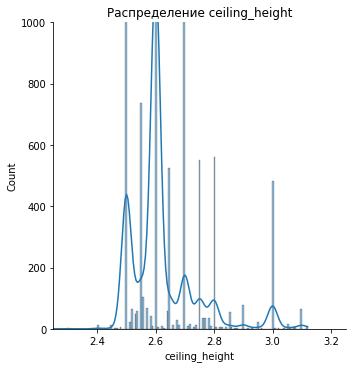

In [ ]:
sns.displot(
  data=data['ceiling_height'],
  kde=True,
  common_norm=False)

plt.xlim(2.25, 3.25)
plt.ylim(0, 1000)
plt.title('Распределение ceiling_height');

## Анализ времени продажи

Построим гистограмму для days_exposition (время продажи). Думаю, разумно считать, что объявления снимались после того, как находился покупатель на квартиру

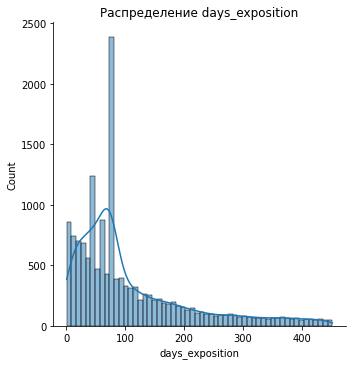

In [ ]:
sns.displot(
  data=data['days_exposition'],
  kde=True,
  common_norm=False)

plt.title('Распределение days_exposition');

Продублируем график boxplot

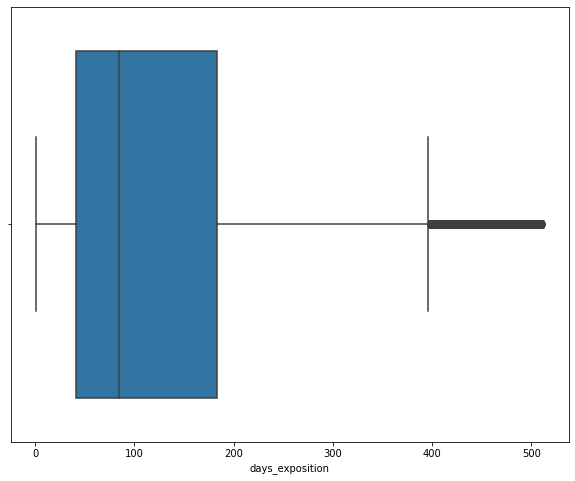

In [ ]:
sns.boxplot(x='days_exposition', data=df);

Среднее по времени продажи

In [ ]:
data['days_exposition'].mean()

109.10662273476112

Медиана по времени продажи

In [ ]:
data['days_exposition'].median()

74.0

Видим, что оценки времени продажи в целом схожи. Скажем, что в среднем продажа занимает около трёх месяцев

Что касается вопросов про быстрые/долгие продажи - наверное, аномально долгой продажей естественно считать все эти черные точки на графике, а быстрой - соответственно, выбросы в обратную сторону, которых у нас нет. Видимо, нулевое значение появляется, когда квартира продаётся в день вывешивания объявления. Но даже это значение очень близко к медиане, поэтому назвать такую продажу быстрой всё равно сложно

## Топ-10 пунктов по числу объявлений

In [ ]:
# Здесь обращаемся к первому попавшемуся столбцу, т.к. они все одинаковые и ранжируем его
top = data.groupby(by=["locality_name"], dropna=False).count().reset_index()[
    ['locality_name', 'total_images']].sort_values(by='total_images', 
                                                   ascending=False)[0:10]
top

,locality_name,total_images
30,Санкт-Петербург,10054
270,посёлок Мурино,399
3,Всеволожск,343
6,Гатчина,266
85,деревня Кудрово,210
275,посёлок Парголово,202
298,посёлок Шушары,192
4,Выборг,191
16,Кудрово,134
107,деревня Новое Девяткино,122


## Средняя тоимость квадратного метра в этих пунктах

Стоимость квадратного метра мы уже считали для каждого объявления (добавили признак). Теперь по сути нужно просто обратиться к строкам, у которых в признаке локация проставлено какое-нибудь значение из топ-10 и затем агрегировать этот признак по городам

In [ ]:
df_for_groupby = data[data['locality_name'].isin(list(top['locality_name']))]
df_for_groupby['locality_name']

1           посёлок Шушары
6        посёлок Парголово
9          Санкт-Петербург
10         Санкт-Петербург
15         Санкт-Петербург
               ...        
23682               Выборг
23686      Санкт-Петербург
23687      Санкт-Петербург
23689      Санкт-Петербург
23690      Санкт-Петербург
Name: locality_name, Length: 12113, dtype: object

In [ ]:
df_for_groupby.groupby(by=['locality_name']).sum()['last_price']

locality_name
Всеволожск                 1.257357e+09
Выборг                     5.554250e+08
Гатчина                    8.953744e+08
Кудрово                    5.904293e+08
Санкт-Петербург            5.290054e+10
деревня Кудрово            8.766672e+08
деревня Новое Девяткино    4.549443e+08
посёлок Мурино             1.437132e+09
посёлок Парголово          8.981490e+08
посёлок Шушары             7.579818e+08
Name: last_price, dtype: float64

## Пункты из топ-10 с самой высокой и низкой стоимостью жилья

Сделаем агрегацию суммой по начальной стоимости last_price

In [ ]:
df_for_groupby.groupby(by=['locality_name']).sum()['last_price']

locality_name
Всеволожск                 1.257357e+09
Выборг                     5.554250e+08
Гатчина                    8.953744e+08
Кудрово                    5.904293e+08
Санкт-Петербург            5.290054e+10
деревня Кудрово            8.766672e+08
деревня Новое Девяткино    4.549443e+08
посёлок Мурино             1.437132e+09
посёлок Парголово          8.981490e+08
посёлок Шушары             7.579818e+08
Name: last_price, dtype: float64

Видим, что Санкт-Петербург обладает самой высокой стоимостью жилья, а деревня Новое Девяткино - самой низкой

## Выделение центральной зоны для Санкт-Петербурга

Выделим объявления, относящиеся к Санкт-Петербургу

In [ ]:
df_SP = data[data['locality_name'] == 'Санкт-Петербург']
df_SP['locality_name']

9        Санкт-Петербург
10       Санкт-Петербург
15       Санкт-Петербург
18       Санкт-Петербург
21       Санкт-Петербург
              ...       
23681    Санкт-Петербург
23686    Санкт-Петербург
23687    Санкт-Петербург
23689    Санкт-Петербург
23690    Санкт-Петербург
Name: locality_name, Length: 10054, dtype: object

Столбец с расстоянием до центра в километрах

In [ ]:
df_SP['cityCenters_nearest_km'] = df_SP['cityCenters_nearest'] // 1000
df_SP['cityCenters_nearest_km']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9        15.0
10       13.0
15       14.0
18       10.0
21        9.0
         ... 
23681     7.0
23686    11.0
23687    16.0
23689    16.0
23690     6.0
Name: cityCenters_nearest_km, Length: 10054, dtype: float64

Сгруппируем строки по расстоянию и для каждого расстояния посчитаем среднюю стоимость

In [ ]:
price_for_km = pd.DataFrame(df_SP.groupby(by=
                                        'cityCenters_nearest_km')['last_price']
                                                          .mean()).reset_index()
price_for_km

,cityCenters_nearest_km,last_price
0,2.0,6.823421e+06
1,3.0,7.077014e+06
2,4.0,7.073951e+06
3,5.0,6.845078e+06
4,6.0,6.173539e+06
5,7.0,6.352454e+06
6,8.0,5.705985e+06
7,9.0,5.114332e+06
8,10.0,5.020313e+06
9,11.0,5.164600e+06


Построим график зависимости цены от удалённости

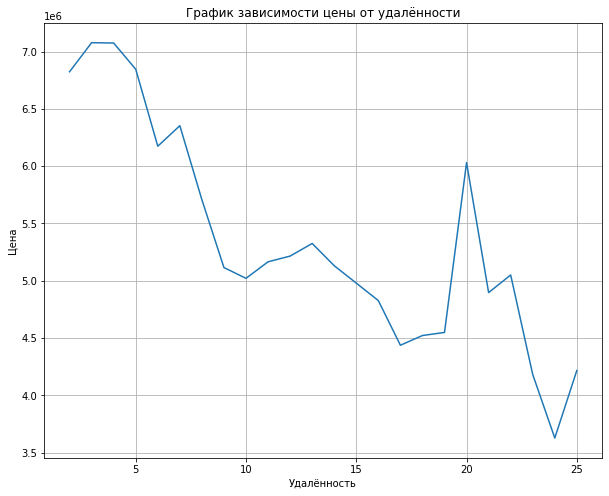

In [ ]:
plt.plot(price_for_km['cityCenters_nearest_km'], price_for_km['last_price']);
plt.title('График зависимости цены от удалённости')
plt.grid(True)
plt.xlabel('Удалённость')
plt.ylabel('Цена');

Наверное, разумно предположить, что центр имеет радиус 7 км, т.к. после этой точки начинается резкий спад (цена быстро падает почти на 3 деления)

In [ ]:
df_SP_center = df_SP[df_SP['cityCenters_nearest_km'] <= 7]
df_SP_center

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,price_of_1m,month,year,day_of_week,floor_cat,area_live_to_total,kitchen_live_to_total,cityCenters_nearest_km
94,3,3500000.0,29.5,2019-04-26,1,2.50,5.0,15.6,2,NaN,...,582.0,4.0,118644.067797,4,2019,4,другой,0.528814,0.186441,7.0
111,4,4590000.0,40.0,2017-05-29,1,2.60,6.0,18.0,1,NaN,...,582.0,31.0,114750.000000,5,2017,0,первый,0.450000,0.250000,6.0
114,5,4000000.0,21.4,2019-02-07,1,2.90,8.0,8.3,7,NaN,...,286.0,74.0,186915.887850,2,2019,3,другой,0.387850,0.294393,5.0
138,8,4800000.0,40.0,2017-11-18,2,2.60,3.0,29.0,2,NaN,...,729.0,80.0,120000.000000,11,2017,5,другой,0.725000,0.150000,2.0
141,8,6500000.0,32.6,2019-02-27,1,2.60,5.0,18.5,5,NaN,...,582.0,74.0,199386.503067,2,2019,2,последний,0.567485,0.168712,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23632,20,5000000.0,38.0,2018-06-23,1,2.55,16.0,28.6,15,NaN,...,230.0,113.0,131578.947368,6,2018,5,другой,0.752632,0.223684,7.0
23644,7,4990000.0,62.5,2018-04-26,2,2.70,4.0,32.3,4,NaN,...,171.0,166.0,79840.000000,4,2018,3,последний,0.516800,0.193600,4.0
23665,11,4250000.0,47.0,2016-05-20,1,2.60,6.0,18.2,1,False,...,519.0,131.0,90425.531915,5,2016,4,первый,0.387234,0.310638,4.0
23681,13,5250000.0,43.0,2018-05-11,2,2.50,5.0,29.0,2,NaN,...,660.0,80.0,122093.023256,5,2018,4,другой,0.674419,0.139535,7.0


## Анализ влияния различных параметров на стоимость

Построим три ML-алгоритма:
- первый будет предсказывать стоимость по всему датасету
- второй только по объявлениям, относящимся к Санкт-Петербургу
- третий только по объявлениям, относящимся к Санкт-Петербургу и находящимся на расстоянии не более 7 км. от центра

В качестве модели выберем CatBoost, т.к. он обычно хорошо работает из коробки, и можно не сильно заморачиваться с подбором гиперпараметров

Удалим столбец is_apartment, т.к. в нём подавляющее большинство значений - пропуски, а также столбец даты и столбец price_of_1_m, т.к. он был построен с помощью целевой переменной

In [ ]:
del data['is_apartment']
del df_SP['is_apartment']
del df_SP_center['is_apartment']

del data['first_day_exposition']
del df_SP['first_day_exposition']
del df_SP_center['first_day_exposition']

del data['price_of_1m']
del df_SP['price_of_1m']
del df_SP_center['price_of_1m']

Метод для вывода метрик

In [ ]:
def r2_adjusted(y_true: list, y_pred: list, X_test: np.array) -> float:
    N_objects = len(y_true)
    N_features = X_test.shape[1]
    r2 = r2_score(y_true, y_pred)
    return 1 - (1 - r2) * (N_objects - 1) / (N_objects - N_features - 1)


def mpe(y_true: list, y_pred: list) -> float:
    return np.mean((y_true - y_pred)/ y_true)


def mape(y_true: list, y_pred: list) -> float:
    return np.mean(np.abs((y_pred - y_true) / y_true))


def wape(y_true: list, y_pred: list) -> float:
    return np.sum(np.abs(y_pred - y_true)) / np.sum(y_true)


def huber_loss(y_true, y_pred, delta):
    assert len(y_true) == len(y_pred), 'Разные размеры данных'
    huber_sum = 0
    for i in range(len(y_true)):
        if abs(y_true[i] - y_pred[i]) <= delta:
            huber_sum += 0.5 * (y_true[i] - y_pred[i])**2
        else:
            huber_sum += delta * (0.5 * abs(y_true[i] - y_pred[i]) -
                                  0.5 * delta)
    huber_sum /= len(y_true)
    return huber_sum


def rmsle(y_true: np.ndarray, y_pred: np.ndarray) -> np.float64:
    """
    The Root Mean Squared Log Error (RMSLE) metric 
    Логаритмическая ошибка средней квадратичной ошибки
    """
    return np.sqrt(mean_squared_log_error(y_true, y_pred))


def get_metrics(y_test, y_pred, X_test, name, delta):
    df_metrics = pd.DataFrame()
    
    df_metrics['model'] = [name]
    
    df_metrics['MAE'] = [mean_absolute_error(y_test, y_pred)]
    df_metrics['MSE'] = [mean_squared_error(y_test, y_pred)]
    df_metrics['RMSE'] = [np.sqrt(mean_squared_error(y_test, y_pred))]
    try:
        df_metrics['RMSLE'] = [rmsle(y_test, y_pred)]
    except:
        df_metrics['RMSLE'] = 0

    df_metrics['R2 adjusted'] = [r2_adjusted(y_test, y_pred, X_test)]
    df_metrics['Huber_loss'] = [huber_loss(y_test, y_pred, delta)]
    df_metrics['MPE_%'] = [mpe(y_test, y_pred)*100]
    df_metrics['MAPE_%'] = [mape(y_test, y_pred)*100]
    df_metrics['WAPE_%'] = [wape(y_test, y_pred)*100]
    
    return df_metrics

Подготовим данные и обучим первый алгоритм

In [ ]:
data = data.dropna()
feature_cols = data.drop(columns = ['last_price'])

X_train, X_test, y_train, y_test = train_test_split(feature_cols,
                                                    data['last_price'],
                                                    test_size=0.16,
                                                    random_state=10)

# Выборки для проверки после каждой итерации обучения
X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.16,
                                                    shuffle=True,
                                                    random_state=10)
eval_set = [(X_val, y_val)]

# Категориальные столбцы
cat_features = ['locality_name', 'floor_cat']

clf = CatBoostRegressor(random_state=10,\
                         cat_features = cat_features)

eval_set = [(X_val, y_val)]

clf.fit(X_train_,
        y_train_,
        eval_set=eval_set,
        early_stopping_rounds=50,
        verbose=2)

Learning rate set to 0.07387
0:	learn: 1888577.2902032	test: 1881134.1532661	best: 1881134.1532661 (0)	total: 70.2ms	remaining: 1m 10s
2:	learn: 1719295.2237388	test: 1714673.8650335	best: 1714673.8650335 (2)	total: 129ms	remaining: 43s
4:	learn: 1577775.7910822	test: 1576232.1337056	best: 1576232.1337056 (4)	total: 190ms	remaining: 37.9s
6:	learn: 1463150.6749401	test: 1463360.5944086	best: 1463360.5944086 (6)	total: 269ms	remaining: 38.1s
8:	learn: 1365929.3663598	test: 1368427.7476788	best: 1368427.7476788 (8)	total: 323ms	remaining: 35.6s
10:	learn: 1281948.8913081	test: 1285824.3412711	best: 1285824.3412711 (10)	total: 374ms	remaining: 33.6s
12:	learn: 1213350.5366665	test: 1218939.2333173	best: 1218939.2333173 (12)	total: 404ms	remaining: 30.7s
14:	learn: 1147228.5499624	test: 1153269.5557357	best: 1153269.5557357 (14)	total: 480ms	remaining: 31.6s
16:	learn: 1092840.6819128	test: 1100727.2673544	best: 1100727.2673544 (16)	total: 543ms	remaining: 31.4s
18:	learn: 1049605.3118289	

Получим предсказания и выведем метрики

In [ ]:
y_pred = clf.predict(X_test)
metrics = get_metrics(list(y_test), y_pred, X_test, name='Catboost', delta=1)

y_pred_train = clf.predict(X_train_)
metrics = metrics.append(
    get_metrics(list(y_train_), y_pred_train, X_train, name='Catboost_train', delta=1))

metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,Huber_loss,MPE_%,MAPE_%,WAPE_%
0,Catboost,531449.920629,5.978945e+11,773236.392511,0.184472,0.854777,265724.460315,-3.822544,13.600262,11.736387
0,Catboost_train,387609.750246,2.717323e+11,521279.456277,0.157545,0.930522,193804.375123,-2.947380,10.979388,8.606164


Видим, что по абсолютным метрикам мы достигли хорошего качества (R2=0.85, WAPE=12%, MAPE=14%, RMSLE=18%)

Теперь проинтерпретируем модель и посмотрим, какие признаки она использовала для предсказания. Это будет нашей оценкой важности факторов

In [ ]:
imp = clf.get_feature_importance(Pool(data=data, cat_features=cat_features))
imp

array([1.76762053e+00, 2.49174844e+01, 1.02325619e+00, 1.54263103e+00,
       7.22149048e+00, 1.46021097e+00, 7.85367342e-01, 3.00239462e-03,
       0.00000000e+00, 5.39379749e+00, 2.02245194e-01, 6.73450712e+00,
       3.67934465e+00, 3.70964279e+01, 1.68022559e-01, 5.06482102e-01,
       2.92054758e-01, 5.42724379e-01, 1.24296147e+00, 6.90933884e-01,
       1.73973266e+00, 2.89421070e-01, 6.13083974e-01, 1.06995691e+00,
       1.01724055e+00])

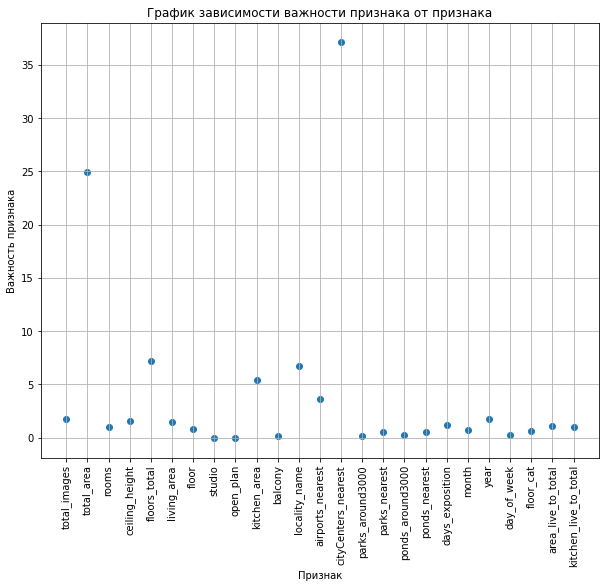

In [ ]:
plt.scatter(feature_cols.columns, imp)
plt.xticks(rotation=90)
plt.title('График зависимости важности признака от признака')
plt.grid(True)
plt.xlabel('Признак')
plt.ylabel('Важность признака');

Видим, что самыми важными признаками оказались площадь и расстояние до центра

Выведем топ-5 для большей наглядности

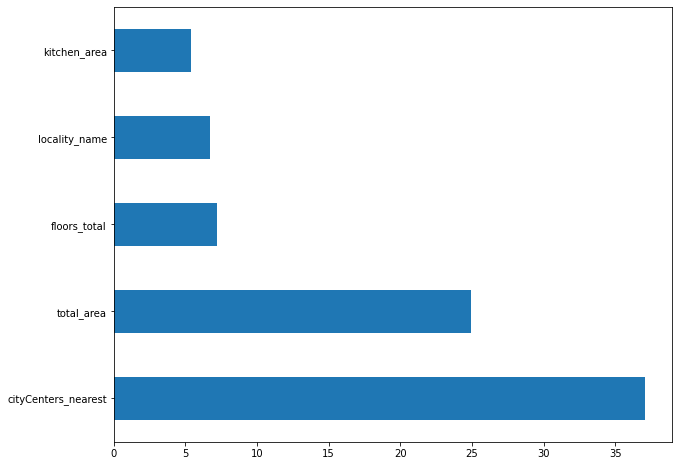

In [ ]:
(pd.Series(clf.feature_importances_, index=feature_cols.columns)
   .nlargest(5)
   .plot(kind='barh')) ;

Сравним результаты с другим методом из библиотеки shap. Он также позволит понять, в какую собственно сторону влияют те или иные признаки на стоимость 

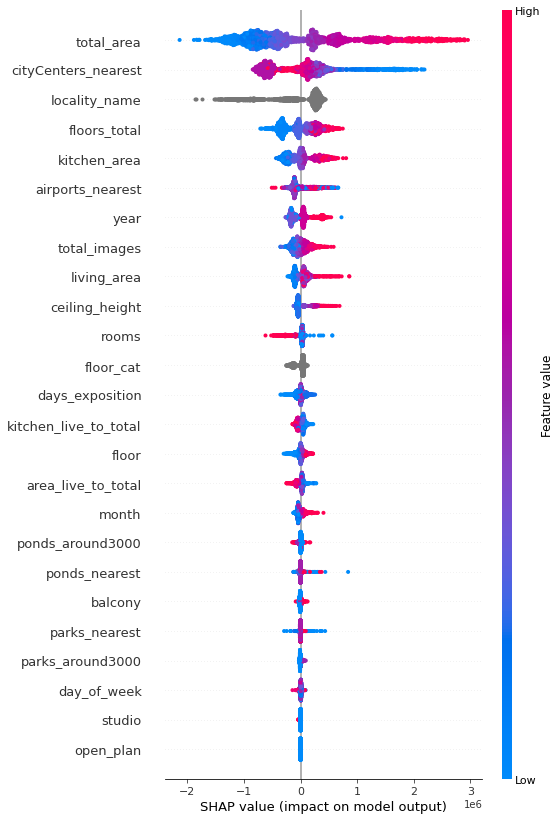

In [ ]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, max_display=200)

Видим, что, например, положительно влияет на стоимость увеличение таких признаков как площадь, количество этажей, площадь кухни, а отрицательно - расстояние до центра, до аэропорта и число комнат, как ни странно. В целом, этот график даёт отличное представление о том, из каких факторов складывался прогноз, и т.к. мы(я) удовлетворены качеством прогноза, то естественно предположить, что и реальная стоимость складывается из этих факторов. Будет также интересно решить эту задачу методами статистики и сравнить результаты (это реализую позже). Также видим, что топ-5 совпали для двух методов

Вывод по заданию - на стоимость влияют площадь, число комнат, удалённость от центра; не влияют - этаж, время размещения

## Анализ влияния различных параметров на стоимость в Санкт-Петербурге

Просто повторим те же самые шаги для второго датасета

In [ ]:
data = df_SP.dropna()
feature_cols = data.drop(columns = ['last_price'])

X_train, X_test, y_train, y_test = train_test_split(feature_cols,
                                                    df_SP['last_price'],
                                                    test_size=0.16,
                                                    random_state=10)

# Выборки для проверки после каждой итерации обучения
X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.16,
                                                    shuffle=True,
                                                    random_state=10)
eval_set = [(X_val, y_val)]

# Категориальные столбцы
cat_features = ['locality_name', 'floor_cat']

clf = CatBoostRegressor(random_state=10,\
                         cat_features = cat_features)

eval_set = [(X_val, y_val)]

clf.fit(X_train_,
        y_train_,
        eval_set=eval_set,
        early_stopping_rounds=50,
        verbose=2)

Learning rate set to 0.069259
0:	learn: 1727069.8989217	test: 1712407.5785196	best: 1712407.5785196 (0)	total: 10.5ms	remaining: 10.5s
2:	learn: 1591673.4520461	test: 1578806.2461457	best: 1578806.2461457 (2)	total: 26ms	remaining: 8.63s
4:	learn: 1475109.8798077	test: 1466193.4578590	best: 1466193.4578590 (4)	total: 39.9ms	remaining: 7.93s
6:	learn: 1377482.5396647	test: 1367608.6648658	best: 1367608.6648658 (6)	total: 53ms	remaining: 7.52s
8:	learn: 1297515.6118611	test: 1287709.9499459	best: 1287709.9499459 (8)	total: 66.9ms	remaining: 7.37s
10:	learn: 1231374.9870019	test: 1224140.7270365	best: 1224140.7270365 (10)	total: 80.4ms	remaining: 7.22s
12:	learn: 1175101.4380119	test: 1168305.4139081	best: 1168305.4139081 (12)	total: 95.1ms	remaining: 7.22s
14:	learn: 1130053.3723998	test: 1125218.1969079	best: 1125218.1969079 (14)	total: 110ms	remaining: 7.2s
16:	learn: 1089184.3215609	test: 1088569.6898695	best: 1088569.6898695 (16)	total: 123ms	remaining: 7.14s
18:	learn: 1054854.46917

Получим предсказания и выведем метрики

In [ ]:
y_pred = clf.predict(X_test)
metrics = get_metrics(list(y_test), y_pred, X_test, name='Catboost', delta=1)

y_pred_train = clf.predict(X_train_)
metrics = metrics.append(
    get_metrics(list(y_train_), y_pred_train, X_train, name='Catboost_train', delta=1))

metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,Huber_loss,MPE_%,MAPE_%,WAPE_%
0,Catboost,542949.614212,5.839870e+11,764190.420739,0.130897,0.821311,271474.307106,-1.495851,10.189926,10.346628
0,Catboost_train,334550.639198,2.055827e+11,453412.275597,0.085228,0.936721,167274.819599,-0.931526,6.544831,6.371893


In [ ]:
imp = clf.get_feature_importance(Pool(data=data, cat_features=cat_features))
imp

array([ 3.13105966, 35.44990239,  1.96939744,  3.23205036,  5.20888142,
        2.54627389,  1.47570459,  0.        ,  0.        ,  8.70652834,
        0.44635558,  0.        ,  6.5761512 ,  9.00641259,  0.4222613 ,
        1.39863615,  0.58399284,  1.67731545,  3.06433768,  1.32693482,
        3.38412657,  0.71360807,  1.45322115,  2.67624662,  1.8362752 ,
        3.71432671])

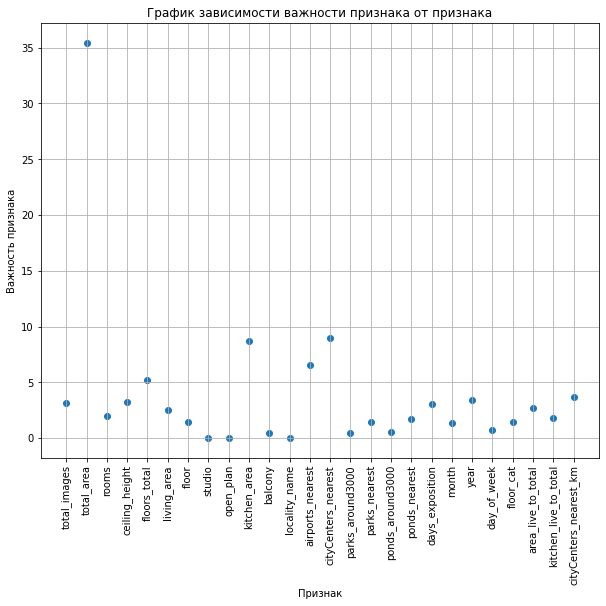

In [ ]:
plt.scatter(feature_cols.columns, imp)
plt.xticks(rotation=90)
plt.title('График зависимости важности признака от признака')
plt.grid(True)
plt.xlabel('Признак')
plt.ylabel('Важность признака');

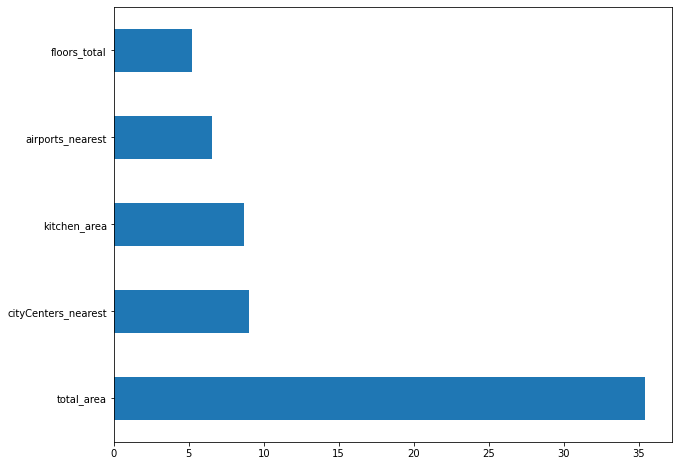

In [ ]:
(pd.Series(clf.feature_importances_, index=feature_cols.columns)
   .nlargest(5)
   .plot(kind='barh')) ;

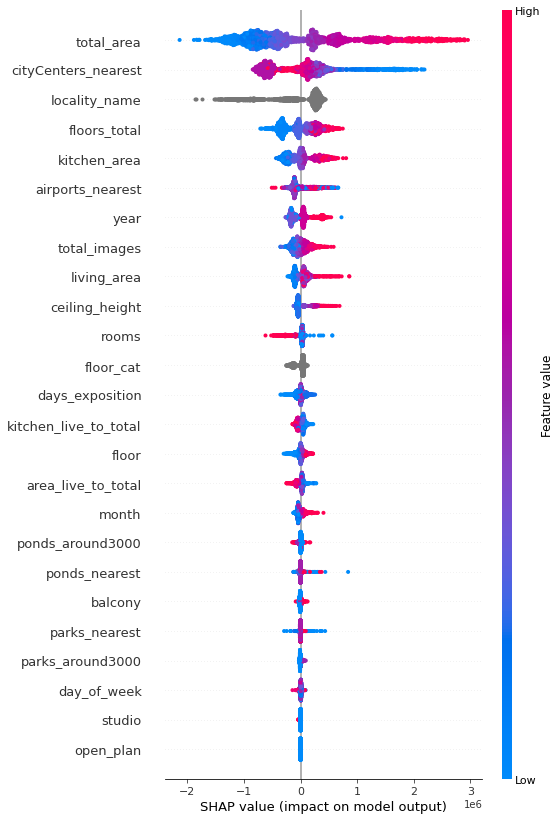

In [ ]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, max_display=200)

Видим, что для Питера в целом результаты почти идентичны, добавляется также влияние расстояния до ближайшего аэропорта

## Анализ влияния различных параметров на стоимость в центре Санкт-Петербурга

Просто повторим те же самые шаги для третьего датасета

In [ ]:
data = df_SP_center.dropna()
feature_cols = data.drop(columns = ['last_price'])

X_train, X_test, y_train, y_test = train_test_split(feature_cols,
                                                    df_SP_center['last_price'],
                                                    test_size=0.16,
                                                    random_state=10)

# Выборки для проверки после каждой итерации обучения
X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.16,
                                                    shuffle=True,
                                                    random_state=10)
eval_set = [(X_val, y_val)]

# Категориальные столбцы
cat_features = ['locality_name', 'floor_cat']

clf = CatBoostRegressor(random_state=10,\
                         cat_features = cat_features)

eval_set = [(X_val, y_val)]

clf.fit(X_train_,
        y_train_,
        eval_set=eval_set,
        early_stopping_rounds=1,
        verbose=2)

Learning rate set to 0.048763
0:	learn: 1955916.2370931	test: 1867588.7302037	best: 1867588.7302037 (0)	total: 3.95ms	remaining: 3.95s
2:	learn: 1875700.7446971	test: 1795091.3250016	best: 1795091.3250016 (2)	total: 14.3ms	remaining: 4.74s
4:	learn: 1809725.8094313	test: 1740401.3566564	best: 1740401.3566564 (4)	total: 41.7ms	remaining: 8.29s
6:	learn: 1749807.6601528	test: 1690475.4633993	best: 1690475.4633993 (6)	total: 55.7ms	remaining: 7.9s
8:	learn: 1692518.6961513	test: 1641842.8742289	best: 1641842.8742289 (8)	total: 63.9ms	remaining: 7.03s
10:	learn: 1637838.3804401	test: 1591531.5611057	best: 1591531.5611057 (10)	total: 75.6ms	remaining: 6.8s
12:	learn: 1586098.9970602	test: 1542117.6550054	best: 1542117.6550054 (12)	total: 85ms	remaining: 6.45s
14:	learn: 1542121.6197457	test: 1502920.0014291	best: 1502920.0014291 (14)	total: 108ms	remaining: 7.08s
16:	learn: 1503807.2243688	test: 1470274.5032332	best: 1470274.5032332 (16)	total: 144ms	remaining: 8.3s
18:	learn: 1467640.39507

Получим предсказания и выведем метрики

In [ ]:
y_pred = clf.predict(X_test)
metrics = get_metrics(list(y_test), y_pred, X_test, name='Catboost', delta=1)

y_pred_train = clf.predict(X_train_)
metrics = metrics.append(
    get_metrics(list(y_train_), y_pred_train, X_train, name='Catboost_train', delta=1))

metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,Huber_loss,MPE_%,MAPE_%,WAPE_%
0,Catboost,1.066247e+06,1.886776e+12,1.373600e+06,0.207400,0.513933,533123.079731,-5.345497,17.034920,15.660175
0,Catboost_train,8.286288e+05,1.135789e+12,1.065734e+06,0.165476,0.704461,414313.909050,-3.767919,13.318271,12.338008


In [ ]:
imp = clf.get_feature_importance(Pool(data=data, cat_features=cat_features))
imp

array([3.71539997e+00, 4.85721235e+01, 2.71973542e-01, 1.07429398e+00,
       7.53134391e+00, 7.16377114e+00, 2.62295370e+00, 1.68540634e-02,
       1.37421394e-03, 8.38266838e+00, 1.07983426e+00, 0.00000000e+00,
       1.72733907e+00, 1.84470417e+00, 1.02831616e+00, 1.04378598e+00,
       7.20259176e-01, 6.01502131e-01, 1.07277974e+00, 5.17759959e-01,
       2.16644588e+00, 8.74043312e-01, 1.44919773e+00, 4.40115557e+00,
       7.19981682e-01, 1.40013874e+00])

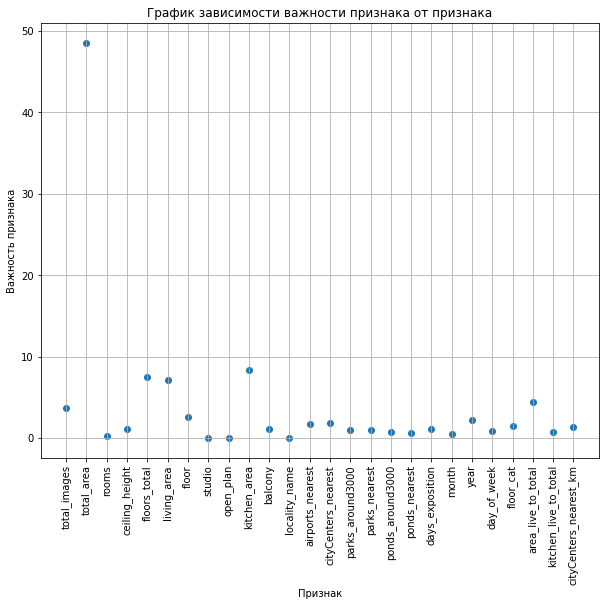

In [ ]:
plt.scatter(feature_cols.columns, imp)
plt.xticks(rotation=90)
plt.title('График зависимости важности признака от признака')
plt.grid(True)
plt.xlabel('Признак')
plt.ylabel('Важность признака');

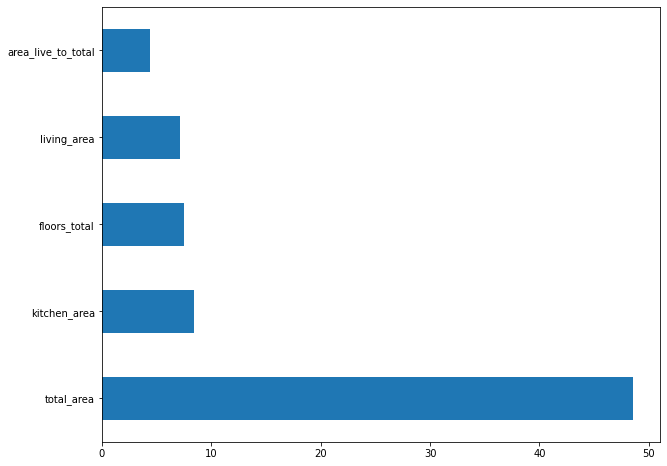

In [ ]:
(pd.Series(clf.feature_importances_, index=feature_cols.columns)
   .nlargest(5)
   .plot(kind='barh')) ;

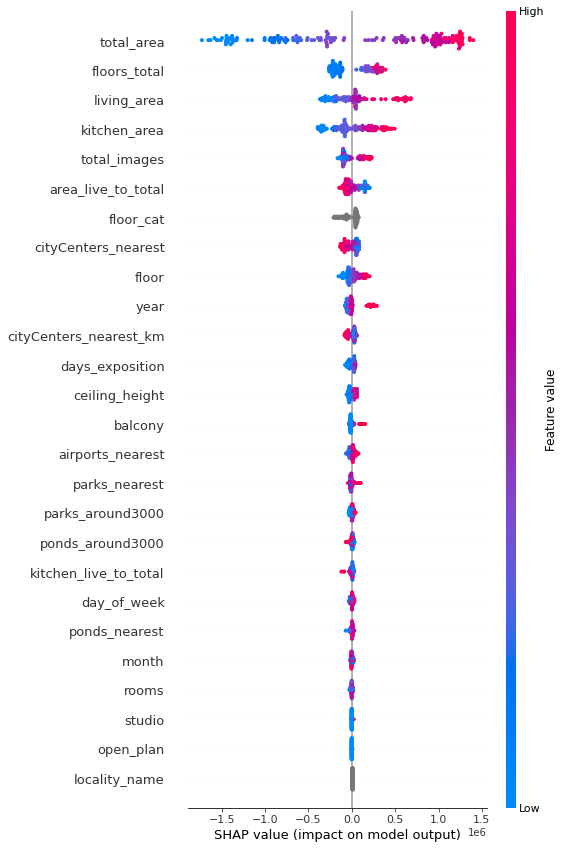

In [ ]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, max_display=200)

Видим, что результаты немного поменялись. Стали сильнее влиять такие признаки как жилая площадь и число фотографий в объявлении, слабее - расстояние до аэропорта. Расстояние до центра и город перестали влиять, что логично, учитывая что мы не рассматриваем объявления вне центра Питера. Единственный нелогичный момент состоит в том, что когда мы рассматривали Питер, имя города было на третьем месте на snap-графике, хотя значения этого признака одинаковы для всех строк. Причем feature_importance показал в этом смысле максимально ожидаемые результаты, т.е. дал нулевую важность центра и города после обучения на третьем датасете и нулевую важность города, но не центра - на втором. Возможно, snap-график просто не очень хорошо подходит для отображения категориальных признаков

## Шаг 5. Общий вывод

Итак, стоимость в большей степени зависит от следующих параметров:

1) Расстояние до центра города

2) Площадь квартиры

3) Число этажей в доме

4) Город

5) Площадь кухни

Для Питера ожидаемо перестаёт влиять город, появляется влияние расстояния до ближайшего аэропорта

Для центра Питера ожидаемо перестают влиять город и расстояние до центра, появляется влияние жилой площади и числа фотографий в объявлении

Более подробные результаты представлены на графиках. Также мы научились предсказывать стоимость квартиры со средней погрешностью на объекте 14% (MAPE - среднее отношение модуля отклонения к реальному значению)